# What is the cause of a drop in Yammer engagements?

An exectutive noticed a trend reversal in their dashboard: about 3-4 weeks ago, the number of unique engaged users stopped increasing (mild weekly increases had occurred for the prior 10-12 weeks) and actually began to decline. 

**Question:** What happened, and should Yammer be worried?? Is some kind of intervention necessary or possible?

*More context: "Yammer defines engagement as having made some type of server call by interacting with the product (shown in the data as events of type “engagement”). Any point in this chart can be interpreted as 'the number of users who logged at least one engagement event during the week starting on that date'.”*


## Initial Exploratory Data Analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

%matplotlib inline

#load the data
yammer_users = pd.read_csv('yammer_users.csv')
yammer_events = pd.read_csv('yammer_events.csv')
yammer_emails = pd.read_csv('yammer_emails.csv')
yammer_experiments = pd.read_csv('yammer_experiments.csv')
dimension_rollup = pd.read_csv('dimension_rollup_periods.csv')

yammer_users.head()

,user_id,created_at,company_id,language,activated_at,state
0,0.0,2013-01-01 20:59:39,5737.0,english,2013-01-01 21:01:07,active
1,1.0,2013-01-01 13:07:46,28.0,english,NaN,pending
2,2.0,2013-01-01 10:59:05,51.0,english,NaN,pending
3,3.0,2013-01-01 18:40:36,2800.0,german,2013-01-01 18:42:02,active
4,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active


In [4]:
# If the dates are currently strings, we'll convert them to date time objects
# so we can easily plot them
type(yammer_users['created_at'][0])

str

In [7]:
from datetime import datetime

# First we convert the created_at column
proper_dates = []

string_dates = list(yammer_users['created_at'])

for index in list(range(len(string_dates))):
    time_value = datetime.strptime(string_dates[index], '%Y-%m-%d %H:%M:%S')
    proper_dates.append(time_value)

yammer_users['proper_dates_cr'] = proper_dates

# Now convert the activated_at column
# For column replacement we'll include Null values,
# but we'll also record just the dates for plotting:
proper_dates = []

string_dates = list(yammer_users['activated_at'])
just_act_dates = []

for index in list(range(len(string_dates))):
    if type(string_dates[index]) == str:
        time_value = datetime.strptime(string_dates[index], '%Y-%m-%d %H:%M:%S')
        proper_dates.append(time_value)
        just_act_dates.append(time_value)
    else:
        proper_dates.append(string_dates[index])

yammer_users['proper_dates_act'] = proper_dates

yammer_users.head()

,user_id,created_at,company_id,language,activated_at,state,proper_dates_cr,proper_dates_act
0,0.0,2013-01-01 20:59:39,5737.0,english,2013-01-01 21:01:07,active,2013-01-01 20:59:39,2013-01-01 21:01:07
1,1.0,2013-01-01 13:07:46,28.0,english,NaN,pending,2013-01-01 13:07:46,NaT
2,2.0,2013-01-01 10:59:05,51.0,english,NaN,pending,2013-01-01 10:59:05,NaT
3,3.0,2013-01-01 18:40:36,2800.0,german,2013-01-01 18:42:02,active,2013-01-01 18:40:36,2013-01-01 18:42:02
4,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active,2013-01-01 14:37:51,2013-01-01 14:39:05


In [8]:
# Even the head of the table shows very old account creation events 
# that never resulted in account activation:
# Let's quickly count how many created accounts never got activated

total_accounts_created = len(yammer_users['proper_dates_cr'])
total_accounts_activated = len(just_act_dates)

print('The number of accounts created was ' + str(total_accounts_created))
print('The number of accounts activated was ' + str(total_accounts_activated))
print('The fraction of created accounts that get activated was ' + str(total_accounts_activated/total_accounts_created))


The number of accounts created was 19066
The number of accounts activated was 9381
The fraction of created accounts that get activated was 0.49202769327598866


In [13]:
# Let's dig in a bit more by looking at a week-by-week view:

days_of_data = max(yammer_users['proper_dates_cr']) - min(yammer_users['proper_dates_cr'])
print(days_of_data)

607 days 16:02:02


In [16]:
weeks_of_data = 607/7
print(weeks_of_data)

86.71428571428571


(0, 550)

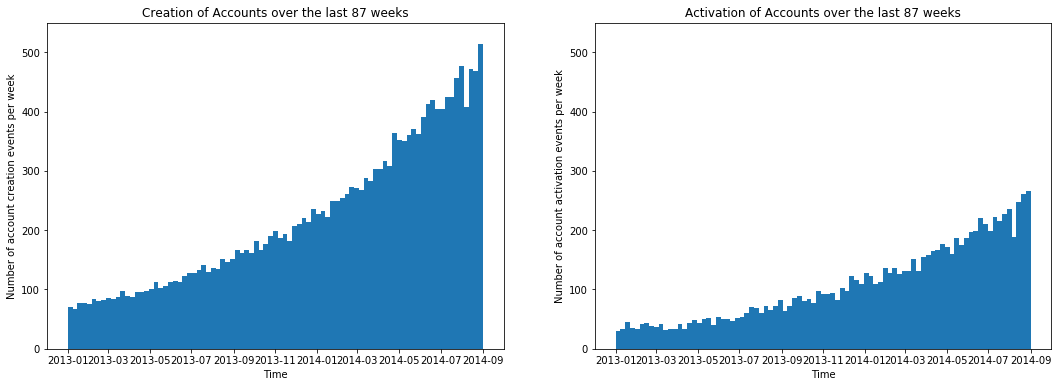

In [24]:
plt.rcParams["figure.figsize"] = (18,6)

plt.subplot(121)
plt.hist(yammer_users['proper_dates_cr'], bins = 87)
plt.title('Creation of Accounts over the last 87 weeks')
plt.xlabel('Time')
plt.ylabel('Number of account creation events per week')
plt.ylim(0,550)

plt.subplot(122)
just_dates = pd.Series(just_dates)
plt.hist(just_dates, bins =87)
plt.title('Activation of Accounts over the last 87 weeks')
plt.xlabel('Time')
plt.ylabel('Number of account activation events per week')
plt.ylim(0,550)

# Discussion:

There is a noticable **weird aberration (or dent) about 3-4 weeks ago** where there is a sudden uncharacteristic drop in the growth of new account creations (we see this dent appears to be echoed "further down our funnel" in the number of accounts activated).  

**Did we have some kind of significant downtime event 3-4 weeks ago that prevented new account creation (or maybe both new account creation and new account activation)?**

The good news is that, immediately after that event, it appears that the strong growth patterns in terms of creation of accounts and also activation of accounts resumes almost as if there had been no interruption...this resumption also makes us suspect that **the dent is not indicative of some real change in rate of demand for account creation.**

We suspect that the observed **decline in the number of engaged users** was a result of a new cohort of users that would have been admitted being reduced due to some technical glitch event. In other words, our **typical observed growth in engaged users requires a new cohort of engaged users to overcome the churn in the existing user base**, but because the size of the entering cohort 3-4 weeks ago was strongly suppressed by some strange glitch event, the  engagement from the diminished-size cophort was not enough to replace our volume of churned engaged users for that time period, leading to an overall decline. 

Let's take a look again at a finer resolution and zoomed in:

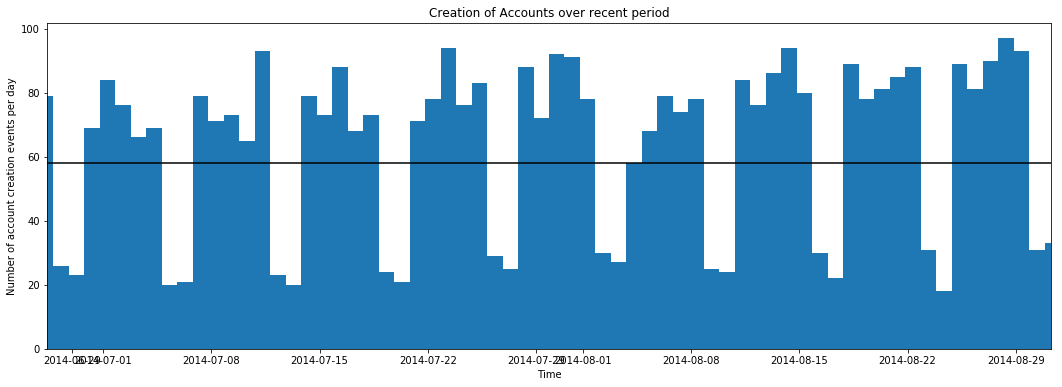

In [29]:
plt.hist(yammer_users['proper_dates_cr'], bins = 607)
plt.title('Creation of Accounts over recent period')
plt.xlabel('Time')
plt.ylabel('Number of account creation events per day')
plt.xlim(just_act_dates[-2100],just_act_dates[-1] )
plt.axhline(y = 58,color ='black')


**The Monday of that week is the lowest day we see for account creation over the last 9-10 weeks.** Tuesday through Friday don't look overwhelmingly strong, but they seem to be much more typical of average levels over the previous weeks.

**Let's see if there is evidence of a technical problem associated with that Monday that perhaps extends into the Tuesday.**